In [ ]:
from google.colab import drive
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import copy
import torch.nn.functional as F

# !cat /proc/meminfo
if torch.cuda.is_available():
  print("CUDA available")
  os.environ['CUDA_VISIBLE_DEVICES'] ='0'

CUDA available


In [ ]:
prefix = '/content/drive'
drive.mount(prefix, force_remount=True)
working_dir = prefix+'/Shareddrives/CIS519'
images_dir = working_dir+'/RAW_DATA/small_dataset/'
print("Working directory: "+working_dir)
print("Images directory: "+images_dir)

Mounted at /content/drive
Working directory: /content/drive/Shareddrives/CIS519
Images directory: /content/drive/Shareddrives/CIS519/RAW_DATA/small_dataset/


In [ ]:
from __future__ import print_function, division

import random
from random import shuffle

import numpy as np
import matplotlib.pyplot as plt
import copy

import os
from os import listdir
from os.path import join

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.utils as vutils
from torchvision import utils, models

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
random.seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)
device = torch.device("cuda")
m = nn.Softmax(dim=1)

In [ ]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 100

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
TRAIN = 'train'
VAL = 'valid'
TEST = 'test'
LABEL = 'labeled'
# images_dir = 'small_dataset'

# GAN Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 64x64 and
        # randomly flip it horizontally. 
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    LABEL: transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(images_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST, LABEL]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size,
        shuffle=True, num_workers=workers        #num_workers=4
    )
    for x in [TRAIN, VAL, TEST, LABEL]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST, LABEL]}

for x in [TRAIN, VAL, TEST, LABEL]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 6000 images under train
Loaded 1200 images under valid
Loaded 1200 images under test
Loaded 100 images under labeled
Classes: 
['fake', 'real']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


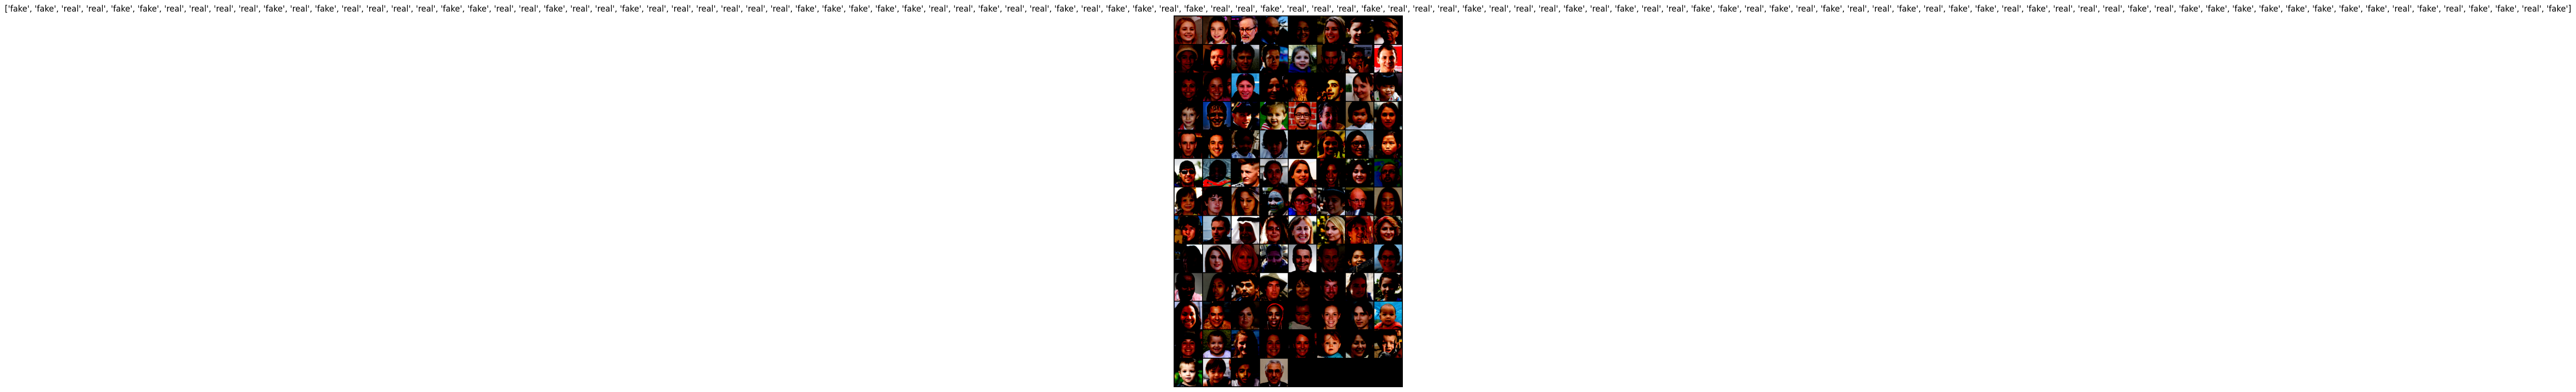

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
class netGeneator(nn.Module):

    def __init__(self, nz, ngf, nc):

        super(netGeneator, self).__init__()
        self.ReLU = nn.ReLU(True)
        self.Tanh = nn.Tanh()
        self.conv1 = nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(ngf * 8)

        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ngf * 4)

        self.conv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ngf * 2)

        self.conv4 = nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ngf * 1)

        self.conv5 = nn.ConvTranspose2d(ngf * 1, nc, 4, 2, 1, bias=False)

        self.apply(weights_init)


    def forward(self, input):

        x = self.conv1(input)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)

        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.ReLU(x)

        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.ReLU(x)

        x = self.conv5(x)
        output = self.Tanh(x)
        return output


class netDiscriminator(nn.Module):

    def __init__(self, ndf, nc, nb_label):

        super(netDiscriminator, self).__init__()
        self.LeakyReLU = nn.LeakyReLU(0.2, inplace=True)
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, ndf * 1, 4, 1, 0, bias=False)
        self.disc_linear = nn.Linear(ndf * 1, 1)
        self.aux_linear = nn.Linear(ndf * 1, nb_label)
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.ndf = ndf
        self.apply(weights_init)

    def forward(self, input):

        x = self.conv1(input)
        x = self.LeakyReLU(x)

        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.LeakyReLU(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.LeakyReLU(x)

        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.LeakyReLU(x)

        x = self.conv5(x)
        x = x.view(-1, self.ndf * 1)
        c = self.aux_linear(x)
        c = self.softmax(c)
        s = self.disc_linear(x)
        s = self.sigmoid(s)
        return s,c

In [ ]:
"""""""""
Pytorch implementation of Conditional Image Synthesis with Auxiliary Classifier GANs (https://arxiv.org/pdf/1610.09585.pdf).
This code is based on Deep Convolutional Generative Adversarial Networks in Pytorch examples : https://github.com/pytorch/examples/tree/master/dcgan
"""""""""
from __future__ import print_function
import argparse
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

netG = netGeneator(nz, ngf, nc)

netD = netDiscriminator(ndf, nc, 2)

s_criterion = nn.BCELoss()
c_criterion = nn.NLLLoss()

input = torch.FloatTensor(batch_size, 3, image_size, image_size)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)
s_label = torch.FloatTensor(batch_size)
c_label = torch.LongTensor(batch_size)

real_label = 1
fake_label = 0

netD.cuda()
netG.cuda()
s_criterion.cuda()
c_criterion.cuda()
input, s_label = input.cuda(), s_label.cuda()
c_label = c_label.cuda()
noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

input = Variable(input)
s_label = Variable(s_label)
c_label = Variable(c_label)
noise = Variable(noise)
fixed_noise = Variable(fixed_noise)
fixed_noise_ = np.random.normal(0, 1, (batch_size, nz))
random_label = np.random.randint(0, 2, batch_size)

random_onehot = np.zeros((batch_size, 2))
random_onehot[np.arange(batch_size), random_label] = 1
fixed_noise_[np.arange(batch_size), :2] = random_onehot[np.arange(batch_size)]


fixed_noise_ = (torch.from_numpy(fixed_noise_))
fixed_noise_ = fixed_noise_.resize_(batch_size, nz, 1, 1)
fixed_noise.data.copy_(fixed_noise_)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 100

def test(predict, labels):
    correct = 0
    pred = predict.data.max(1)[1]
    correct = pred.eq(labels.data).cpu().sum()
    return correct, len(labels.data)


train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

best_acc = 0

for epoch in range(num_epochs):
    train_loss = 0
    train_accuracy = 0
    k = 0
    for i, data in enumerate(dataloaders[TRAIN], 0):
        k += 1
        ###########################
        # (1) Update D network
        ###########################
        # train with real
        netD.zero_grad()
        img, label = data
        batch_size = img.size(0)
        input.data.resize_(img.size()).copy_(img)
        s_label.data.resize_(batch_size).fill_(real_label)
        c_label.data.resize_(batch_size).copy_(label)
        s_output, c_output = netD(input)
        s_output = s_output.type(dtype=torch.float).squeeze().to(device)
        s_errD_real = s_criterion(s_output, s_label)
        c_errD_real = c_criterion(c_output, c_label)
        errD_real = s_errD_real + c_errD_real
        errD_real.backward()
        D_x = s_output.data.mean()

        correct, length = test(c_output, c_label)
        train_accuracy += correct / length

        # train with fake
        noise.data.resize_(batch_size, nz, 1, 1)
        noise.data.normal_(0, 1)

        label = np.random.randint(0, 2, batch_size)
        noise_ = np.random.normal(0, 1, (batch_size, nz))
        label_onehot = np.zeros((batch_size, 2))
        label_onehot[np.arange(batch_size), label] = 1
        noise_[np.arange(batch_size), :2] = label_onehot[np.arange(batch_size)]

        noise_ = (torch.from_numpy(noise_))
        noise_ = noise_.resize_(batch_size, nz, 1, 1)
        noise.data.copy_(noise_)

        c_label.data.resize_(batch_size).copy_(torch.from_numpy(label))

        fake = netG(noise)
        s_label.data.fill_(fake_label)
        s_output, c_output = netD(fake.detach())
        s_output = s_output.type(dtype=torch.float).squeeze().to(device)
        s_errD_fake = s_criterion(s_output, s_label)
        c_errD_fake = c_criterion(c_output, c_label)
        errD_fake = s_errD_fake + c_errD_fake

        errD_fake.backward()
        D_G_z1 = s_output.data.mean()
        errD = s_errD_real + s_errD_fake
        optimizerD.step()

        ###########################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        s_label.data.fill_(real_label)  # fake labels are real for generator cost
        s_output, c_output = netD(fake)
        s_output = s_output.type(dtype=torch.float).squeeze().to(device)
        s_errG = s_criterion(s_output, s_label)
        c_errG = c_criterion(c_output, c_label)

        errG = s_errG + c_errG
        errG.backward()
        D_G_z2 = s_output.data.mean()
        optimizerG.step()
        train_loss += errD.data

        # if i % 100 == 0:
        #     vutils.save_image(img, 'real_samples.png')
        #     #fake = netG(fixed_cat)
        #     fake = netG(fixed_noise)
        #     vutils.save_image(fake.data, 'fake_samples_epoch_%03d.png' % (epoch))

    # do checkpointing
    train_loss /= k
    train_losses.append(train_loss)
    train_accuracies.append(100. * train_accuracy / i)

    validation_accuracy = 0
    validation_loss = 0
    total = 0
    correct_total = 0
    k = 0
    for batch_number, (validation_img, validation_label) in enumerate(dataloaders[VAL]):
        k += 1
        batch_size = validation_img.size(0)
        input.data.resize_(validation_img.size()).copy_(validation_img)
        s_label.data.resize_(batch_size).fill_(real_label)
        c_label.data.resize_(batch_size).copy_(validation_label)
        s_output, c_output = netD(input)
        correct, length = test(c_output, c_label)
        total += length
        correct_total += correct
        
        s_output = s_output.type(dtype=torch.float).squeeze().to(device)
        s_errD_real = s_criterion(s_output, s_label)
        c_errD_real = c_criterion(c_output, c_label)
        errD_real = s_errD_real + c_errD_real
        D_x = s_output.data.mean()

        fake = netG(noise)
        s_label.data.fill_(fake_label)
        s_output, c_output = netD(fake.detach())
        s_output = s_output.type(dtype=torch.float).squeeze().to(device)
        s_errD_fake = s_criterion(s_output, s_label)
        c_errD_fake = c_criterion(c_output, c_label)
        errD_fake = s_errD_fake + c_errD_fake

        D_G_z1 = s_output.data.mean()
        errD = s_errD_real + s_errD_fake
        validation_loss += errD.data
    
    validation_loss /= k
    validation_losses.append(validation_loss)
    validation_accuracy = 100. * correct_total / total
    validation_accuracies.append(validation_accuracy)
    # if validation_accuracy > best_acc:
    #     best_acc = validation_accuracy
    #     torch.save(netG.state_dict(), 'netG_epoch_%d.pth' % (epoch))
    #     torch.save(netD.state_dict(), 'netD_epoch_%d.pth' % (epoch))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f903a7e6f70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f903a7e6f70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

In [ ]:
train_losses = torch.stack(train_losses)
train_accuracies = torch.stack(train_accuracies)
validation_losses = torch.stack(validation_losses)
validation_accuracies = torch.stack(validation_accuracies)
print(train_losses)
print(train_accuracies)
print(validation_losses)
print(validation_accuracies)

tensor([0.5043, 0.6042, 0.8424, 0.5771, 0.5859, 0.6411, 0.7548, 0.7648, 0.6912,
        0.7680, 0.6632, 0.6647, 0.6804, 0.5363, 0.6171, 0.5706, 0.5717, 0.4568,
        0.6225, 0.6626, 0.6523, 0.7120, 0.6014, 0.6382, 0.5665, 0.5569, 0.6460,
        0.6516, 0.4423, 0.7925, 0.5207, 0.5224, 0.6101, 0.4620, 0.5364, 0.5393,
        0.6200, 0.5035, 0.7790, 0.4768, 0.7796, 0.4904, 0.8342, 0.4450, 0.5887,
        0.5876, 0.5954, 0.7029, 0.5557, 0.6853, 0.5016, 0.9262, 0.4149, 0.5007,
        0.7497, 0.5548, 0.5214, 0.6793, 0.5548, 0.7039, 0.5823, 0.6030, 0.4826,
        0.6076, 0.5567, 0.6246, 0.3990, 0.8364, 0.5756, 0.4301, 0.5938, 0.5606,
        0.6904, 0.3244, 0.6911, 0.4959, 0.2917, 0.7805, 0.3791, 0.7292, 0.4239,
        0.2644, 1.2970, 0.3130, 0.5043, 0.3245, 0.3135, 1.0377, 0.4226, 0.6605,
        0.2461, 0.4202, 0.5410, 0.2451, 0.8614, 0.3214, 0.6951, 0.3249, 0.4037,
        0.2312], device='cuda:0')
tensor([64.8475, 73.9322, 74.6102, 75.0339, 75.6610, 77.5593, 77.6780, 77.4237,
      

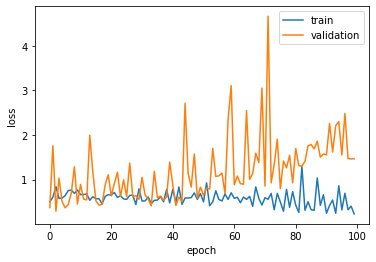

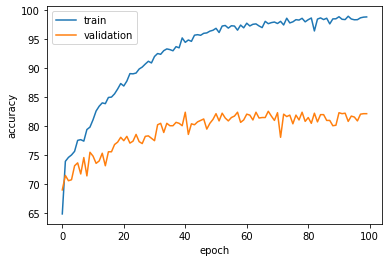

In [ ]:
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(range(len(train_losses)), np.array(train_losses.cpu()), label="train")
plt.plot(range(len(validation_losses)), np.array(validation_losses.cpu()), label="validation")
plt.legend()
plt.show()

plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(range(len(train_accuracies)), np.array(train_accuracies.cpu()), label="train")
plt.plot(range(len(validation_accuracies)), np.array(validation_accuracies.cpu()), label="validation")
plt.legend()
plt.show()

In [ ]:
print('Best VAL validation accuracy: ', np.max(np.array(validation_accuracies)),
      '% after ', np.argmax(np.array(validation_accuracies)), ' training epochs')

PATH = 'netD_epoch_%d.pth' % np.argmax(np.array(validation_accuracies))

model = netDiscriminator(ndf, nc, 2)
model.load_state_dict(torch.load(PATH))
model = model.to(device)
model.eval()
test_accuracy = 0
total = 0
correct_total = 0
for batch_number, (test_img, test_label) in enumerate(dataloaders[TEST]):
    test_img = test_img.to(device)
    test_label = test_label.to(device)
    batch_size = test_img.size(0)
    input.data.resize_(test_img.size()).copy_(test_img)
    s_label.data.resize_(batch_size).fill_(real_label)
    c_label.data.resize_(batch_size).copy_(test_label)
    s_output, c_output = model(input)
    correct, length = test(c_output, c_label)
    total += length
    correct_total += correct

test_accuracy = 100. * correct_total / total
print("\nBest model on the testing set: ")
print('\nTesting set: Accuracy: {}/{} ({:.0f}%)\n'.format(correct_total, total, test_accuracy))

Best VAL validation accuracy:  83.25 % after  67  training epochs

Best model on the testing set: 

Testing set: Accuracy: 988/1200 (82%)

